 # **Career and Job Search Assistant**
A domain-specific assistant is an AI assistant that is trained to focus on one particular field instead of knowing a little about everything. This assistant is specialized in helping entry-level job seekers improve resumes, prepare for interviews, and understand job search strategies. It focuses on ATS optimization, resume bullet improvement, and interview preparation. We are going to use a large language model (pre-trained model) and train it again on the specific dataset so that it becomes a specialized support in job hunting.
New imports are used for this task such as **Dataset** which is from **Hugging Face's dataset library** converting data into a foramt optimized for training LLMs as hugging face expect the datat in their Dataset format.
# **Objective**


- Develop an AI assistant trained to help entry-level job seekers improve resumes, prepare for interviews, and optimize job search strategies.


*   Dataset: Curate at 3000 Q&A resume tips for training.

In [1]:
!pip install --upgrade kagglehub
!pip install pandas datasets transformers -q
!pip install transformers datasets accelerate peft bitsandbytes -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [kagglehub]/4 [kagglehub]

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
! pip install matplot

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 93.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 112.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 94.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.2/633.2 kB 24.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.5/811.5 kB 32.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 92.7 MB/s  0:00:00
  Created wheel for SimpleWebSocketServer: filename=simplewebsockets

In [1]:
import numpy as np                     # embedding and math
import os
import re                              # remove noise
import pandas as pd                    # clean the Q&A
import torch                           # deep learning framework
import matplotlib.pyplot as plt

import math
from transformers import BitsAndBytesConfig
from datasets import Dataset
from transformers import (
    AutoTokenizer,             # converts text => numbers(tokens)
    AutoModelForCausalLM,       #
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_from_disk, load_dataset
import kagglehub
from kagglehub import KaggleDatasetAdapter


In [2]:
# download the dataset
path = kagglehub.dataset_download("rodasgoniche/seeker")

print("Path to dataset files:", path)
# Construct the full path to the CSV file
csv_file_path = os.path.join(path, "career__dataset_3000.csv")
# Read the CSV file using the correct path
df = pd.read_csv(csv_file_path)
df.head()

Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/rodasgoniche/seeker/versions/1


,id,entry_type,target_audience,role,region,question,answer,ml_tag
0,1,ats_keywords,all_job_seekers,UX Designer,Africa,What ATS keywords should a UX Designer include...,"Include keywords such as ux designer, core too...",finetuning
1,2,mock_interview,all_job_seekers,UX Designer,Africa,Mock interview question for an entry-level UX ...,Describe a project where you applied relevant ...,finetuning
2,3,ats_keywords,all_job_seekers,Data Analyst,Global Remote,What ATS keywords should a Data Analyst includ...,"Include keywords such as data analyst, core to...",finetuning
3,4,ats_keywords,all_job_seekers,IT Support,US/EU,What ATS keywords should a IT Support include ...,"Include keywords such as it support, core tool...",finetuning
4,5,resume_rewrite,all_job_seekers,Data Analyst,Africa,Rewrite this resume bullet for a Data Analyst:...,Bad: Worked on projects and helped the team. |...,finetuning


In [3]:

# clean the dataset
def clean_text(text):
  text = str(text)

  # remove extra spaces
  text = re.sub(r"\s+", " ", text)
  # remove weird characters except punctuation
  text = re.sub(r"[^a-zA-Z0-9.,!?;:'\"()\- ]", "", text)
  # strip trailing spaces
  text = text.strip()

  return text


In [4]:
# apply the cleaning
df["question"] = df["question"].apply(clean_text)
df["answer"] = df["answer"].apply(clean_text)

In [5]:
# remove empty or bad rows
df = df.dropna()
df= df[df["question"].str.len() > 5]
df = df[df["answer"].str.len() > 5]
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

In [6]:
print("Final dataset size:", len(df))
print(df.head(5)[['question', 'answer']])

Final dataset size: 3000
                                            question  \
0  What ATS keywords should a UX Designer include...   
1  Mock interview question for an entry-level UX ...   
2  What ATS keywords should a Data Analyst includ...   
3  What ATS keywords should a IT Support include ...   
4  Rewrite this resume bullet for a Data Analyst:...   

                                              answer  
0  Include keywords such as ux designer, core too...  
1  Describe a project where you applied relevant ...  
2  Include keywords such as data analyst, core to...  
3  Include keywords such as it support, core tool...  
4  Bad: Worked on projects and helped the team.  ...  


The format_prompt(row) function takes each row of the DataFrame and formats the question and answer columns into a structured prompt. Initially it use a simple ###questions / ###answer format, then redefine the function to use a chat-style format with <|system|>, <|user|>, and <|assistant|> roles (which is better for instruction/chat model training).

This part helps in formatting, cleaning, and validating your training data before using it to fine-tune a model.

In [7]:
def format_prompt(row):
  return f"""###questions:
{row['question']}

###answer:
{row['answer']}"""

df["text"] = df.apply(format_prompt, axis=1)
df["text"].iloc[0]
def format_prompt(row):
    return f"""<|system|>
You are a career assistant specializing in resumes and interview preparation.

<|user|>
{row['question']}

<|assistant|>
{row['answer']}"""

df["text"] = df.apply(format_prompt, axis=1)
df["text"].iloc[0]

# final check for rows where the question/answer are just punctuation
df = df[df['question'].str.strip().str.len() > 0]
df = df[df['answer'].str.strip().str.len() > 0]

for i in range(3):
    print(df['text'].iloc[i])
    print("-----")

<|system|>
You are a career assistant specializing in resumes and interview preparation.

<|user|>
What ATS keywords should a UX Designer include for roles in Africa?

<|assistant|>
Include keywords such as ux designer, core tools, methodologies, and certifications commonly listed in Africa-based job postings.
-----
<|system|>
You are a career assistant specializing in resumes and interview preparation.

<|user|>
Mock interview question for an entry-level UX Designer role.

<|assistant|>
Describe a project where you applied relevant skills for a UX Designer. Focus on problem, action, and result.
-----
<|system|>
You are a career assistant specializing in resumes and interview preparation.

<|user|>
What ATS keywords should a Data Analyst include for roles in Global Remote?

<|assistant|>
Include keywords such as data analyst, core tools, methodologies, and certifications commonly listed in Global Remote-based job postings.
-----


In [8]:
dataset = Dataset.from_pandas(df[["text"]])
dataset

Dataset({
    features: ['text'],
    num_rows: 3000
})

This code is splitting my dataset into training and validation sets.

dataset.train_test_split(test_size=0.1, seed=42)
Splits the dataset into:

90% for training

10% for validation (testing)
* The seed=42 ensures the split is reproducible (so that we get the same split every time we run it).

In [9]:
# Split into train and validation
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")

Training samples: 2700
Validation samples: 300


This code is preparing the tokenizer for my model.

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0" - specifying which pretrained model from Hugging Face I want to use

This loads the tokenizer that matches that model which converts text into tokens (numbers) that the model understands.
Some models (like TinyLlama) don’t have a default padding token so set the padding token to be the same as the end-of-sequence (eos_token). This prevents errors during batching.


In [10]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# load tokenizer/use small model tokenizer for efficiency
tokenizer = AutoTokenizer.from_pretrained(model_name)
# required for padding
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

This code prepares my dataset for training a chat model in a way that makes it easier for the model to learn. First, it converts the text into tokens (numbers) that the model can understand, truncating long texts to 512 tokens and padding shorter ones so all sequences are the same length. Then, it creates labels for training: it ignores everything before <|assistant|> (the user’s question and prompt) by setting those tokens to -100, and only uses the tokens after <|assistant|> (the assistant’s reply) as the target for the model to predict. This ensures the model focuses on generating correct answers rather than trying to predict the question. Finally, it applies this process to the entire training and validation datasets and removes the original text column, leaving only the tokenized inputs and labels, making the dataset ready for supervised fine-tuning.

In [11]:
def tokenize(example):
    texts = example["text"]

    tokenized = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=512
    )

    labels = []

    for i, input_ids in enumerate(tokenized["input_ids"]):
        text = texts[i]

        # Find assistant start
        assistant_marker = "<|assistant|>"
        assistant_index = text.find(assistant_marker)

        if assistant_index == -1:
            labels.append([-100] * len(input_ids))
            continue

        # Tokenize prefix (everything before assistant answer)
        prefix = text[:assistant_index + len(assistant_marker)]
        prefix_ids = tokenizer(
            prefix,
            truncation=True,
            max_length=512
        )["input_ids"]

        assistant_start_token_index = len(prefix_ids)

        example_labels = []

        for j, token_id in enumerate(input_ids):
            if token_id == tokenizer.pad_token_id:
                example_labels.append(-100)
            elif j < assistant_start_token_index:
                example_labels.append(-100)
            else:
                example_labels.append(token_id)

        labels.append(example_labels)

    tokenized["labels"] = labels
    return tokenized

train_tokenized = train_dataset.map(tokenize, batched=True)
eval_tokenized = eval_dataset.map(tokenize, batched=True)

train_tokenized = train_tokenized.remove_columns(["text"])
eval_tokenized = eval_tokenized.remove_columns(["text"])

print(train_tokenized[0])
print(eval_tokenized[0])
print(train_tokenized[0]["labels"][:60])

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

{'input_ids': [1, 529, 29989, 5205, 29989, 29958, 13, 3492, 526, 263, 6413, 20255, 4266, 5281, 297, 620, 9351, 322, 15593, 10223, 362, 29889, 13, 13, 29966, 29989, 1792, 29989, 29958, 13, 5618, 319, 9375, 29361, 881, 263, 13315, 18601, 3160, 363, 16178, 297, 10557, 29973, 13, 13, 29966, 29989, 465, 22137, 29989, 29958, 13, 29419, 29361, 1316, 408, 372, 2304, 29892, 7136, 8492, 29892, 1158, 11763, 29892, 322, 2284, 8232, 15574, 9904, 297, 10557, 29899, 6707, 4982, 1400, 886, 29889, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

This code sets up a data collator, which is responsible for preparing batches of data during training. It takes the tokenized inputs and labels and combines them into batches the model can process efficiently. Here, DataCollatorForLanguageModeling is used with mlm=False because this is a causal/decoder-only model, not a masked language model. That means the model will predict the next token in the sequence (like a chat response) rather than trying to fill in missing words. Essentially, the collator handles padding, batching, and label alignment automatically so the training loop can run smoothly.

In [12]:
# this prepares batches during training
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

In [13]:
from huggingface_hub import login, upload_folder
login(os.getenv("HF_Token"))

This gives a baseline score to compare against after the fine-tune the model, so that we can see how much it improves.

In [14]:
# Load base model WITHOUT quantization
baseline_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto"
)

baseline_args = TrainingArguments(
    output_dir="/tmp/baseline",
    per_device_eval_batch_size=2,
    do_train=False,
    do_eval=True,
    report_to="none"
)

baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    eval_dataset=eval_tokenized,
    data_collator=data_collator
)

baseline_results = baseline_trainer.evaluate()
baseline_loss = baseline_results["eval_loss"]
baseline_perplexity = math.exp(baseline_loss)

print("Baseline Loss:", baseline_loss)
print("Baseline Perplexity:", baseline_perplexity)

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Baseline Loss: 2.688645362854004
Baseline Perplexity: 14.711733355537186


In [18]:
import time
start = time.time()

Run a series of experiments to fine-tune a chat model with different hyperparameters and saves the results for comparison. For each experiment, it prints the experiment name, reloads a fresh base model with 8-bit quantization to save memory, and enables gradient checkpointing to reduce GPU usage. It then applies LoRA adapters to the model, which allow efficient fine-tuning by only training small low-rank matrices instead of the full model. Training arguments are set according to the experiment’s learning rate, batch size, number of epochs, optimizer type, and evaluation strategy, including automatic evaluation and early stopping to prevent overfitting. A Trainer object handles the training loop using the tokenized datasets and a data collator to prepare batches. After training, the model is evaluated on the validation set, and the evaluation loss is converted to perplexity to measure prediction quality. The trained LoRA adapters and tokenizer are saved, and all results including hyperparameters, loss, and perplexity are appended to a list, so you can later compare which configuration performed best.

In [ ]:
experiments = [
    {"name": "exp1", "lr": 2e-4, "batch": 2, "epochs": 2, "optimizer": "paged_adamw_8bit"},
    {"name": "exp2", "lr": 1e-4, "batch": 2, "epochs": 2, "optimizer": "paged_adamw_8bit"},
    {"name": "exp3", "lr": 1e-4, "batch": 2, "epochs": 3, "optimizer": "paged_adamw_8bit"},
    {"name": "exp4", "lr": 5e-5, "batch": 2, "epochs": 3, "optimizer": "paged_adamw_8bit"},
    {"name": "exp5", "lr": 1e-4, "batch": 4, "epochs": 2, "optimizer": "paged_adamw_8bit"},
    {"name": "exp6", "lr": 1e-4, "batch": 4, "epochs": 2, "optimizer": "adamw_torch"},
    {"name": "exp7", "lr": 5e-5, "batch": 4, "epochs": 3, "optimizer": "adamw_torch"},
]

results = []

for exp in experiments:
    print(f"\n==============================")
    print(f" Running {exp['name']}")
    print(f"==============================")

    # Reload quantized base model (fresh each experiment)
    quant_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
        )

    base_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=quant_config,
        device_map="auto"
    )

    base_model.gradient_checkpointing_enable()
    base_model.config.use_cache = False

    # Apply LoRA again (fresh adapters)
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.CAUSAL_LM
    )

    model = get_peft_model(base_model, lora_config)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"/teamspace/studios/this_studio/career_model_{exp['name']}",
        per_device_train_batch_size=exp["batch"],
        gradient_accumulation_steps=4,
        learning_rate=exp["lr"],
        num_train_epochs=exp["epochs"],
        logging_steps=50,
        save_strategy="steps",
        save_steps=50,
        eval_strategy="steps", # Changed to 'steps'
        eval_steps=50,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        fp16=True,
        optim=exp["optimizer"],
        report_to="none"
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=eval_tokenized,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train
    trainer.train()

    # Evaluate
    eval_results = trainer.evaluate()
    eval_loss = eval_results["eval_loss"]
    perplexity = math.exp(eval_loss)

    print(f"{exp['name']} done.")
    print(f"Eval Loss: {eval_loss:.4f}")
    print(f"Perplexity: {perplexity:.2f}")

    # Save adapters
    trainer.save_model(f"/tmp/career_model_{exp['name']}_final")
    tokenizer.save_pretrained(f"/tmp/career_model_{exp['name']}_final")

    # Store results
    results.append({
        "experiment": exp["name"],
        "lr": exp["lr"],
        "batch": exp["batch"],
        "epochs": exp["epochs"],
        "optimizer": exp["optimizer"],
        "eval_loss": eval_loss,
        "perplexity": perplexity
    })


 Running exp1


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
50,1.281867,0.197238
100,0.080947,0.053733
150,0.051245,0.049323
200,0.046488,0.048448
250,0.046186,0.045939
300,0.045370,0.044260
350,0.045135,0.043651
400,0.044527,0.043694
450,0.042396,0.044008


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/aut

exp1 done.
Eval Loss: 0.0437
Perplexity: 1.04

 Running exp2


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
50,1.840420,0.906377
100,0.375146,0.103413
150,0.072855,0.055824
200,0.052836,0.052017
250,0.050438,0.049684
300,0.049059,0.047463
350,0.048075,0.045994
400,0.046829,0.045391
450,0.044030,0.046779
500,0.045658,0.044885


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/aut

exp2 done.
Eval Loss: 0.0443
Perplexity: 1.05

 Running exp3


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
50,1.835829,0.894048
100,0.368449,0.109086
150,0.073190,0.055376
200,0.052292,0.050509
250,0.049946,0.050719
300,0.048853,0.049341
350,0.047535,0.045464
400,0.047029,0.045966
450,0.044370,0.045813


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/aut

exp3 done.
Eval Loss: 0.0455
Perplexity: 1.05

 Running exp4


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
50,2.251322,1.720085
100,1.143505,0.668543
150,0.379383,0.154123
200,0.099621,0.071893
250,0.063691,0.059689
300,0.056736,0.053143
350,0.053248,0.051006
400,0.051328,0.050780
450,0.048022,0.048953
500,0.049178,0.048127


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/aut

exp4 done.
Eval Loss: 0.0462
Perplexity: 1.05

 Running exp5


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
50,1.832632,0.910934
100,0.411017,0.099475
150,0.069351,0.053918
200,0.052909,0.049408
250,0.048715,0.049048
300,0.047820,0.047224


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/aut

exp5 done.
Eval Loss: 0.0472
Perplexity: 1.05

 Running exp6


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
50,1.821791,0.886050
100,0.386415,0.096254
150,0.067854,0.055060
200,0.052883,0.051156
250,0.049586,0.049860
300,0.048279,0.048178


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/aut

exp6 done.
Eval Loss: 0.0482
Perplexity: 1.05

 Running exp7


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
50,2.229885,1.694002
100,1.162897,0.674722
150,0.381482,0.163529
200,0.109547,0.075179
250,0.065367,0.058242
300,0.058323,0.054776
350,0.053972,0.052124
400,0.051799,0.052415
450,0.051623,0.050201
500,0.050486,0.050805


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/bitsandbytes/aut

exp7 done.
Eval Loss: 0.0502
Perplexity: 1.05


In [24]:
end = time.time()
print("Training time:", (end-start)/60, "minutes")

Training time: 358.4860473394394 minutes


In [25]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("perplexity")
df_results.to_csv("/teamspace/studios/this_studio/hyperparameter_experiments_results.csv", index=False)
print("\n=== All experiments completed ===")
print(df_results)


=== All experiments completed ===
  experiment       lr  batch  epochs         optimizer  eval_loss  perplexity
0       exp1  0.00020      2       2  paged_adamw_8bit   0.043651    1.044618
1       exp2  0.00010      2       2  paged_adamw_8bit   0.044331    1.045328
2       exp3  0.00010      2       3  paged_adamw_8bit   0.045464    1.046514
3       exp4  0.00005      2       3  paged_adamw_8bit   0.046224    1.047309
4       exp5  0.00010      4       2  paged_adamw_8bit   0.047224    1.048357
5       exp6  0.00010      4       2       adamw_torch   0.048178    1.049357
6       exp7  0.00005      4       3       adamw_torch   0.050201    1.051482


In [26]:
model.save_pretrained("/teamspace/studios/this_studio/career_finetuned")
tokenizer.save_pretrained("/teamspace/studios/this_studio/career_finetuned")
best_exp = df_results.iloc[0]["experiment"]
print("The best Experiment is:", best_exp)

The best Experiment is: exp1


In [27]:
best_model_path = f"/teamspace/studios/this_studio/career_model_{best_exp}_final"
print("Best model path:", best_model_path)

Best model path: /teamspace/studios/this_studio/career_model_exp1_final


this code below loads the LoRA-fine-tuned TinyLlama, formats a chat-style prompt, generates a career-assistant response, and saves the model for future use.

In [32]:
from peft import PeftModel

BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
ADAPTER_PATH = "/teamspace/studios/this_studio/career_finetuned"

# tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

# base model
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    device_map="auto"
)

# attach LoRA adapter
model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)

model.eval()
from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

messages = [
    {"role": "system", "content": "You are a professional career assistant."},
    {"role": "user", "content": "Improve this resume summary for a software developer."}
]

prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

result = pipe(
    prompt,
    max_new_tokens=300,
    temperature=0.7,
    top_p=0.9,
    do_sample=True
)

print(result[0]["generated_text"])
save_path = "/teamspace/studios/this_studio/career_finetuned"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Passing `generation_config` together with generation-related arguments=({'temperature', 'max_new_tokens', 'top_p', 'do_sample'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
Both `max_new_tokens` (=300) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|system|>
You are a professional career assistant.</s>
<|user|>
Improve this resume summary for a software developer.</s>
<|assistant|>
Job: Software Developer 

Summary: Partnering with a team to create high-quality applications for remote work. 

Keywords: Software Development, Remote, Team, Creation, Remote Work

Relevant skills: Adapting to remote work, Collaborating with teams, Designing and implementing applications


('/teamspace/studios/this_studio/career_finetuned/tokenizer_config.json',
 '/teamspace/studios/this_studio/career_finetuned/chat_template.jinja',
 '/teamspace/studios/this_studio/career_finetuned/tokenizer.json')

In [ ]:
upload_folder(
    repo_id="helinow/careermate",
    folder_path=save_path,
    commit_message="Upload fine-tuned career assistant model"
)

In [33]:
!pip install evaluate rouge_score nltk
import math
from tqdm import tqdm
import evaluate
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
def generate_predictions(model, tokenizer, dataset, text_column="text", num_samples=50):
    preds, refs = [], []
    model.eval()

    for i in tqdm(range(min(num_samples, len(dataset)))):
        sample = dataset[i][text_column]

        inputs = tokenizer(sample, return_tensors="pt", truncation=True).to(model.device)

        with torch.no_grad():
            output = model.generate(**inputs, max_new_tokens=100)

        pred = tokenizer.decode(output[0], skip_special_tokens=True)

        preds.append(pred)
        refs.append(sample)

    return preds, refs


predictions, references = generate_predictions(
    model,
    tokenizer,
    eval_dataset
)
bleu_score = bleu.compute(
    predictions=predictions,
    references=[[r] for r in references]
)

rouge_score = rouge.compute(
    predictions=predictions,
    references=references
)

print("BLEU:", bleu_score)
print("ROUGE:", rouge_score)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.1 MB/s  0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24987 sha256=81f0f45d611b1b522550daa2d6b0cc1b49f01b328f0a7a590786a4760e39d4a5
  Stored in directory: /home/zeus/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [evaluate]4/5 [evaluate]

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


100%|██████████| 50/50 [03:37<00:00,  4.35s/it]


BLEU: {'bleu': 0.4654638484014235, 'precisions': [0.47116875793035384, 0.4674144540678688, 0.4636064636064636, 0.45974362667434826], 'brevity_penalty': 1.0, 'length_ratio': 2.1223818073010174, 'translation_length': 7093, 'reference_length': 3342}
ROUGE: {'rouge1': np.float64(0.6251228623588074), 'rouge2': np.float64(0.6203996211251745), 'rougeL': np.float64(0.6247831816435676), 'rougeLsum': np.float64(0.6246501802930141)}


In [34]:
def calculate_perplexity(model, tokenizer, dataset, text_column="text", num_samples=50):

    losses = []

    for i in tqdm(range(min(num_samples, len(dataset)))):

        text = dataset[i][text_column]

        inputs = tokenizer(text, return_tensors="pt", truncation=True).to(model.device)

        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])

        losses.append(outputs.loss.item())

    avg_loss = sum(losses) / len(losses)
    perplexity = math.exp(avg_loss)

    return perplexity


100%|██████████| 50/50 [00:02<00:00, 18.28it/s]


In [36]:
import pandas as pd

results_df = pd.DataFrame({
    "Metric": ["BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L", "Perplexity"],
    "Score": [
        bleu_score["bleu"],
        rouge_score["rouge1"],
        rouge_score["rouge2"],
        rouge_score["rougeL"],
        ppl
    ]
})

results_df

,Metric,Score
0,BLEU,0.465464
1,ROUGE-1,0.625123
2,ROUGE-2,0.620400
3,ROUGE-L,0.624783
4,Perplexity,1.053394


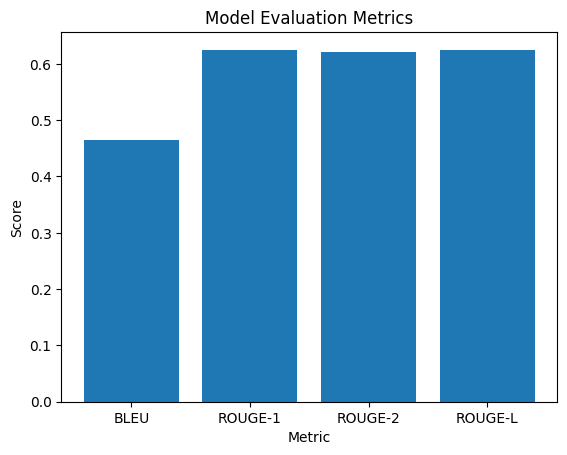

In [37]:
import matplotlib.pyplot as plt

metrics = {
    "BLEU": bleu_score["bleu"],
    "ROUGE-1": rouge_score["rouge1"],
    "ROUGE-2": rouge_score["rouge2"],
    "ROUGE-L": rouge_score["rougeL"]
}

plt.figure()
plt.bar(metrics.keys(), metrics.values())
plt.title("Model Evaluation Metrics")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.show()

,Metric,Score
0,BLEU,0.465464
1,ROUGE-1,0.625123
2,ROUGE-2,0.620400
3,ROUGE-L,0.624783
4,Perplexity,1.053394


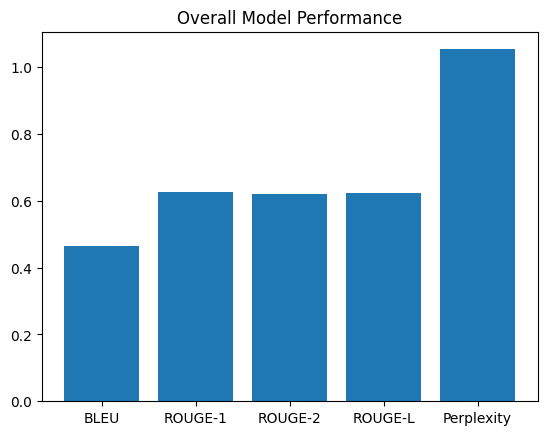

In [38]:
import pandas as pd

results_df = pd.DataFrame({
    "Metric": ["BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L", "Perplexity"],
    "Score": [
        bleu_score["bleu"],
        rouge_score["rouge1"],
        rouge_score["rouge2"],
        rouge_score["rougeL"],
        ppl
    ]
})

display(results_df)

plt.figure()
plt.bar(results_df["Metric"], results_df["Score"])
plt.title("Overall Model Performance")
plt.show()

In [ ]:
https://github.com/rodwol/chatbot_careermate.git